In [38]:
import sys
import math

sys.path.append('../')

import numpy as np
import pylab as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn import datasets

from models.utils.spectral_normalization import spectral_norm_linear
from models.utils.random_features import RandomFeatureGaussianProcess
from models.resnet_sngp import train_one_epoch

# Regression

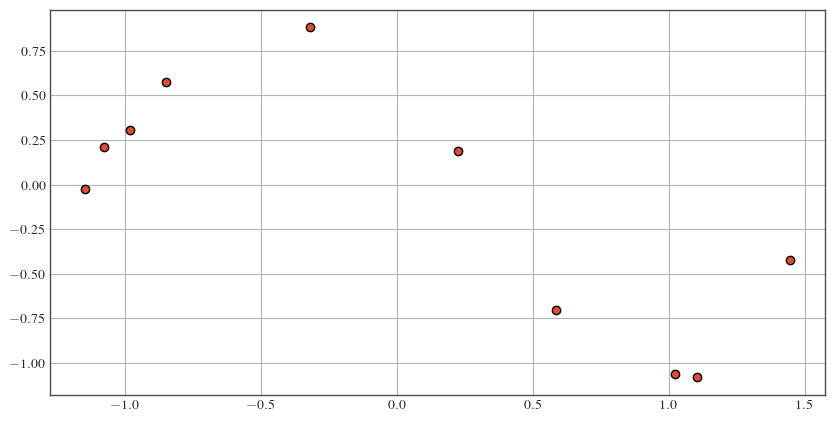

In [69]:
torch.manual_seed(3)
n_samples = 10
X = torch.empty(n_samples).uniform_(0, 1).view(-1, 1)
y = torch.sin(2 * torch.pi *X)
y += torch.randn_like(y)*0.1

X = (X - X.mean(0)) / X.std(0)

train_ds = torch.utils.data.TensorDataset(X, y)

plt.scatter(X, y)
plt.show()

In [92]:
class LinearModel(nn.Module):
    def __init__(self, order, out_features=1):
        super().__init__()
        self.order = order
        self.weight = nn.Parameter(torch.randn(out_features, order+1))
        # self.bias = nn.Parameter(torch.randn(out_features))

        self.prior_precision_data = 100
        self.prior_precision_params = 10

    def phi(self, x):
        x = torch.cat([x**i for i in range(0, self.order+1)], dim=1)
        return x

    def forward(self, input):
        return F.linear(self.phi(input), weight=self.weight, bias=None)
    
    def compute_precision(self, input):
        phi = self.phi(input)
        self.precision = phi.T@phi + self.prior_precision_params*torch.eye(phi.size(1))
        self.covariance = torch.linalg.pinv(self.precision)

    @torch.no_grad()
    def log_marg_likelihood(self, inputs, targets):

        N, D = len(inputs), self.order

        logits = self(inputs)
        neg_log_likelihood = N/2*math.log(2*math.pi*self.prior_precision_data**-1) 
        neg_log_likelihood = self.prior_precision_data/2 *F.mse_loss(logits, targets, reduction='sum') 
        # neg_log_likelihood = F.binary_cross_entropy_with_logits(logits, targets, reduction='sum')
        neg_log_prior =  self.prior_precision_params/2 * torch.sum(self.weight**2)
        neg_log_posterior = neg_log_likelihood + neg_log_prior

        log_det = torch.logdet(self.precision)
        lml = -neg_log_posterior + D/2 * math.log(2*math.pi) - log_det/2
        return lml


In [93]:
def train_one_epoch(model, train_loader, optimizer):
    running_loss = 0
    n_samples = 0
    for X_batch, y_batch in train_loader:

        model.train()

        out = model(X_batch)
        loss = F.mse_loss(out, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_size = len(X_batch)
        n_samples += batch_size
        running_loss += loss
    train_stats = { 'train_loss': (running_loss / n_samples).item(), }
    return train_stats

1 {'train_loss': 0.018435802310705185}


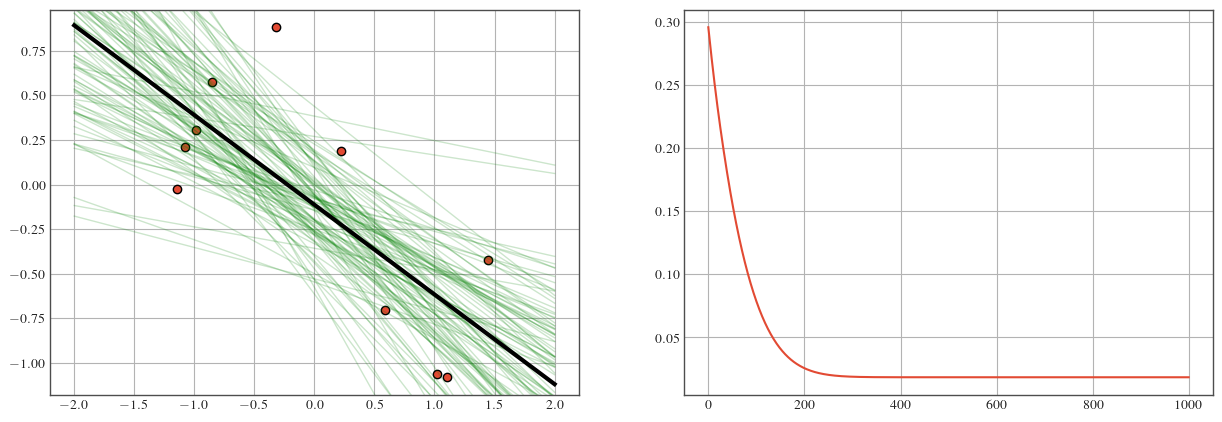

2 {'train_loss': 0.0161580853164196}


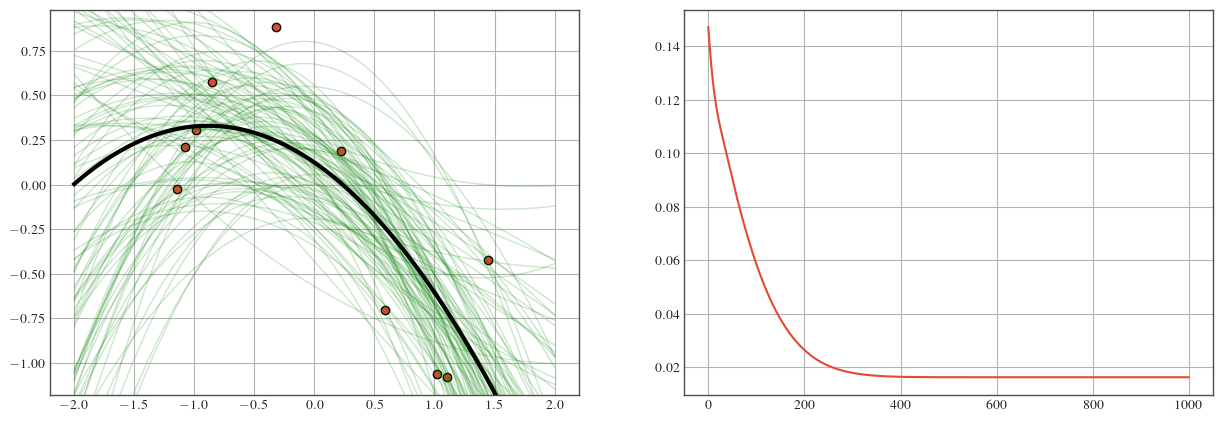

3 {'train_loss': 0.0010654632933437824}


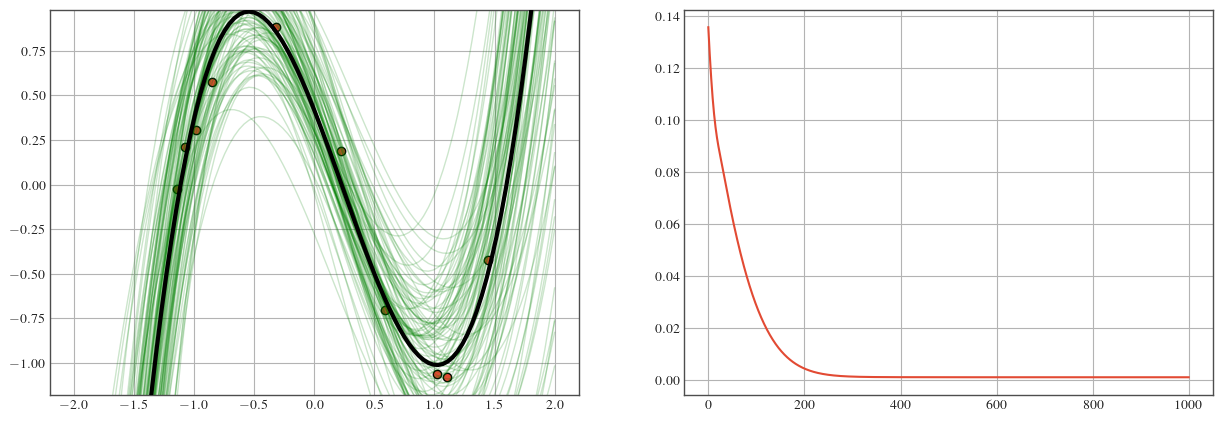

4 {'train_loss': 0.0003290747117716819}


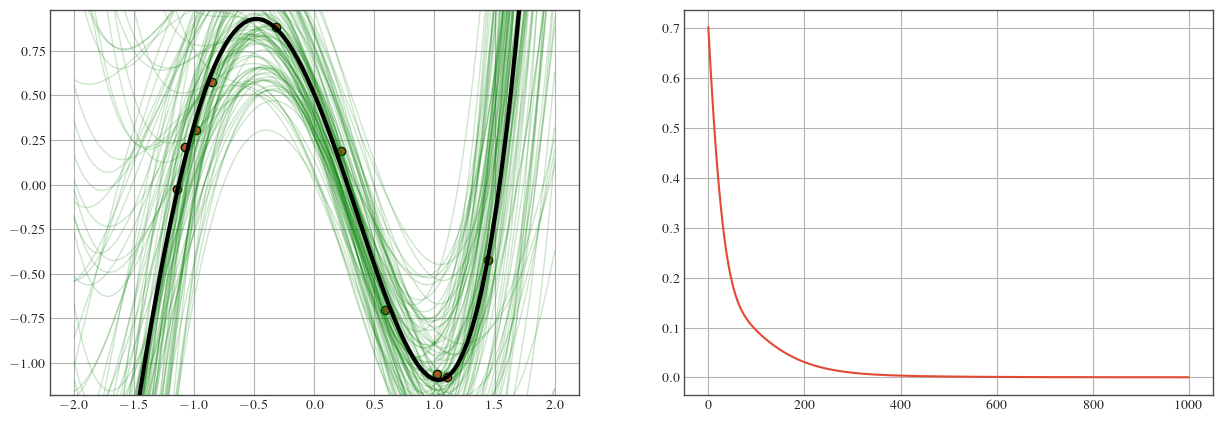

5 {'train_loss': 0.000376963202143088}


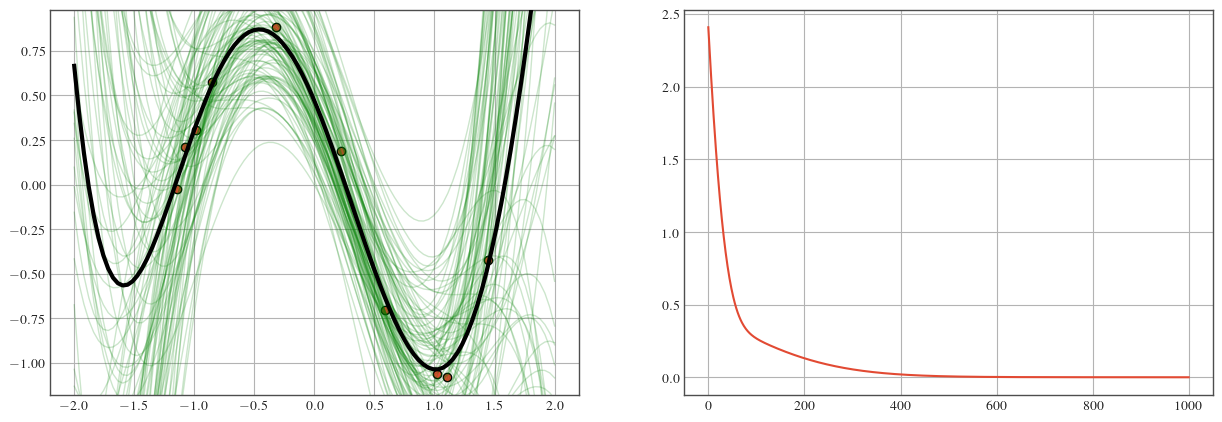

6 {'train_loss': 0.004063006024807692}


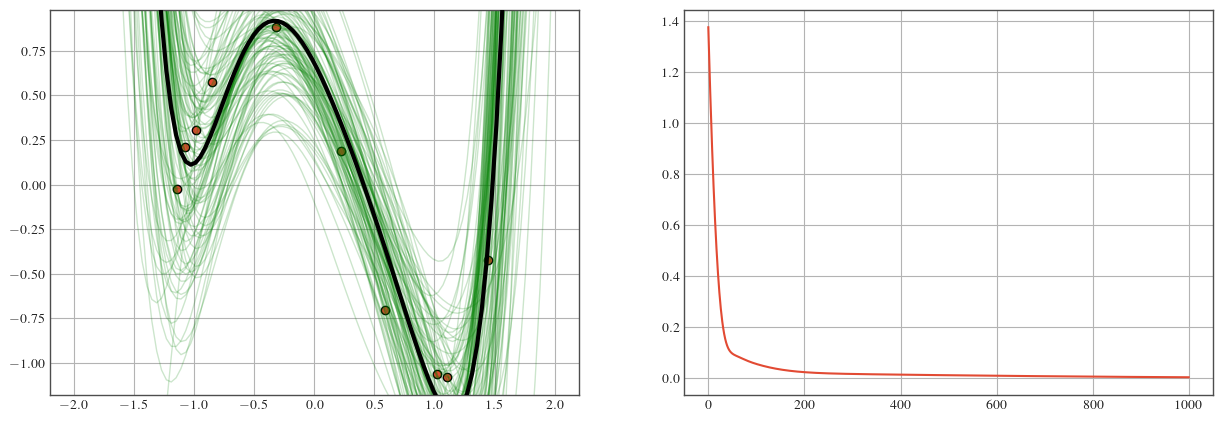

7 {'train_loss': 0.0003281679528299719}


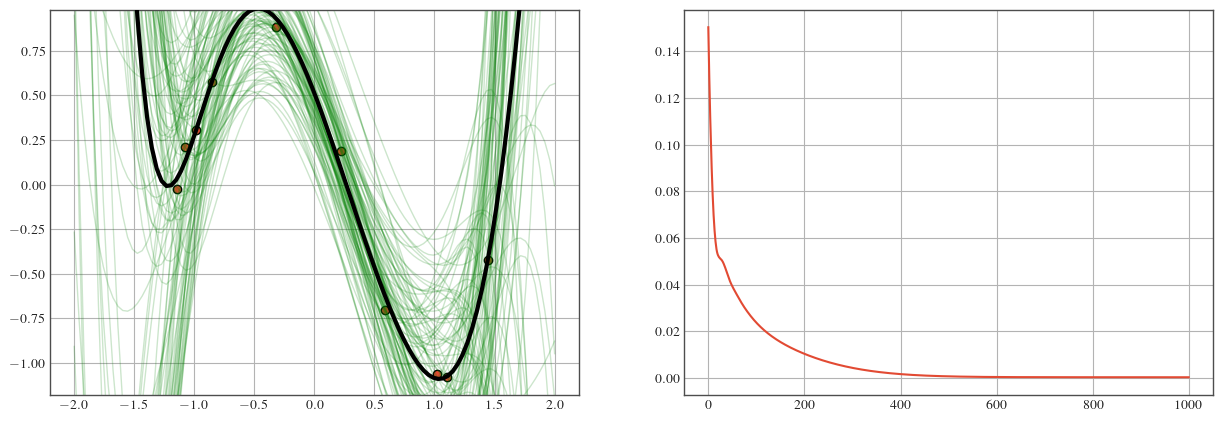

8 {'train_loss': 0.0021735269110649824}


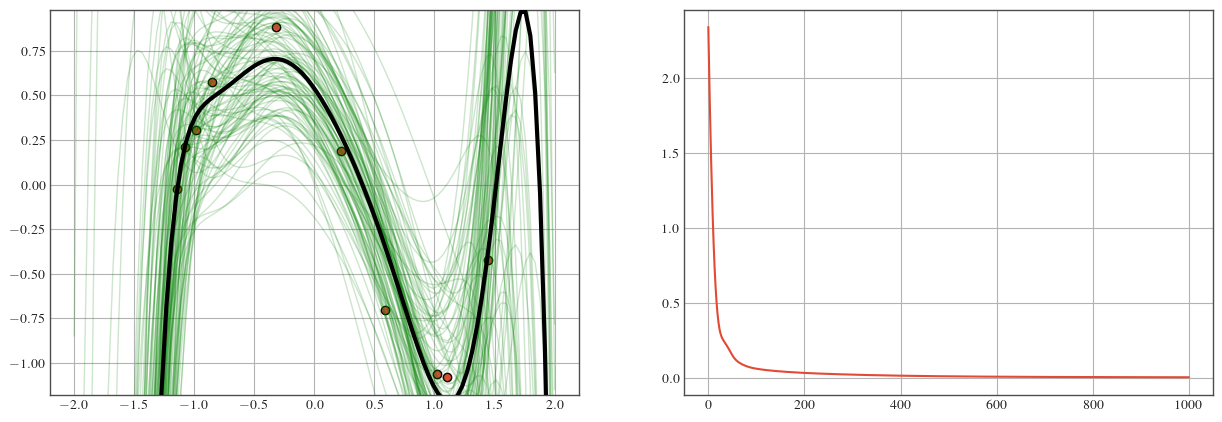

9 {'train_loss': 0.0023058478254824877}


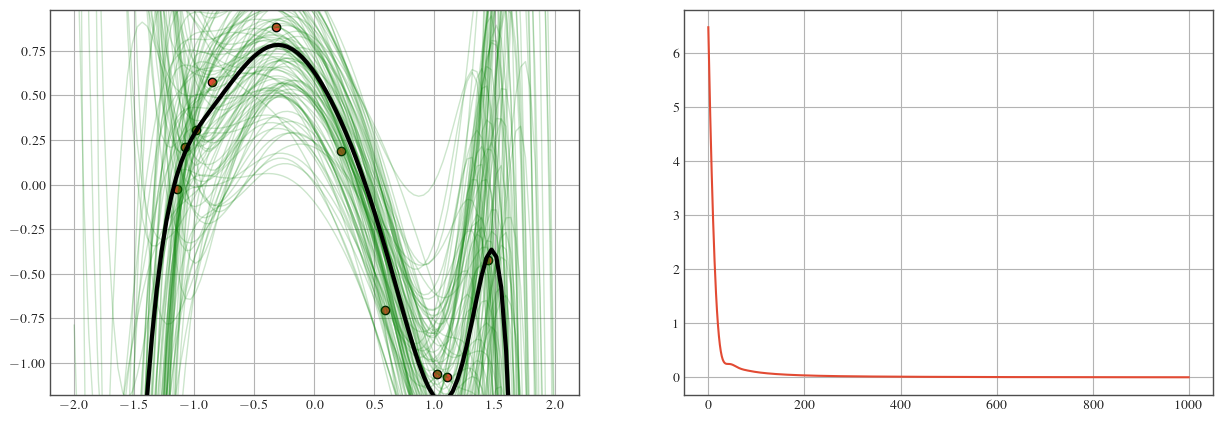

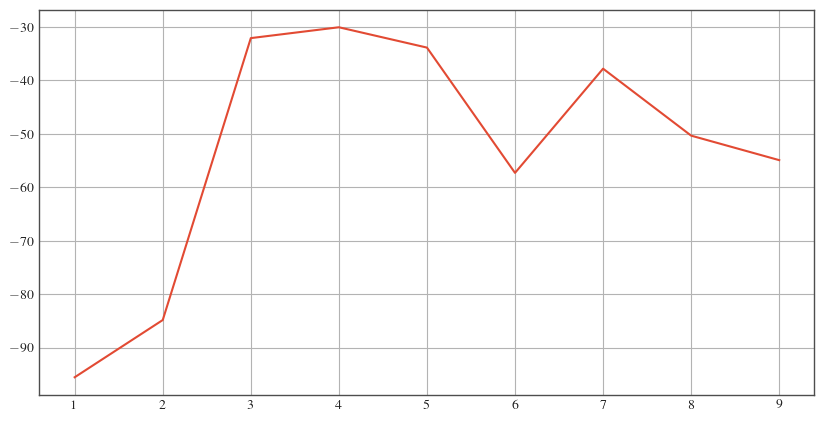

In [94]:
lmls = []
orders = range(1, 10)
for order in orders:
    n_epochs = 1000

    torch.manual_seed(0)
    model = LinearModel(order)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-2, weight_decay=1e-3)
    train_loader = torch.utils.data.DataLoader(train_ds, batch_size=10, shuffle=True, drop_last=True)

    history = []
    for i in range(n_epochs):
        train_stats = train_one_epoch(model, train_loader, optimizer)
        history.append(train_stats)

    # Laplace approximation
    model.compute_precision(X)
    mean = model.weight.data
    cov = model.covariance
    posterior = torch.distributions.MultivariateNormal(mean, precision_matrix=model.precision)
    lml =  model.log_marg_likelihood(X, y)
    lmls.append(lml)

    print(order, history[-1])
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    axis = torch.linspace(-2, 2, 100)

    plt.scatter(X, y)
    plt.ylim(*plt.ylim())
    with torch.no_grad():
        axis_pred = model(axis.view(-1, 1))
    plt.plot(axis, axis_pred.squeeze(), color='k', linewidth=3, zorder=4)
    for w in posterior.sample((100,)):
        phi = model.phi(axis.view(-1, 1))
        out = F.linear(phi, w)
        plt.plot(axis, out.squeeze(), color='g', linewidth=1, alpha=.2)

    plt.subplot(122)
    plt.plot([d['train_loss'] for d in history])
    plt.show()


plt.figure()
plt.plot(orders, lmls)
plt.show()

# Classification

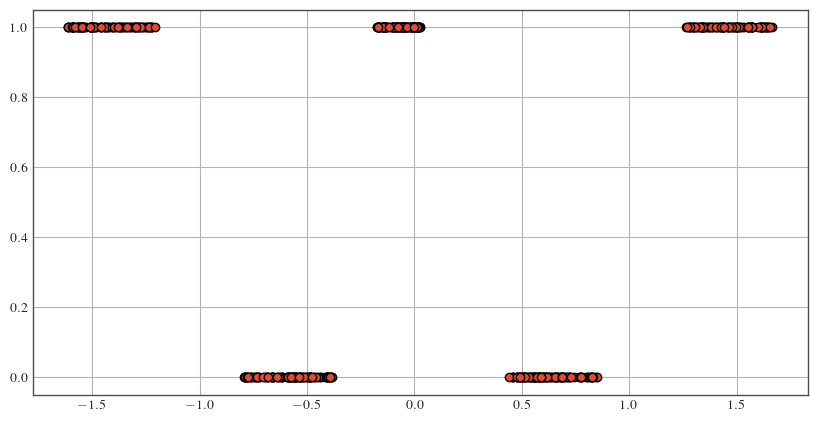

In [224]:
torch.manual_seed(3)
n_samples = 100
# X = torch.empty(n_samples).uniform_(-3, 3).view(-1, 1)
X = torch.cat([
    torch.empty(n_samples).uniform_(-3, -2).view(-1, 1),
    torch.empty(n_samples).uniform_(-1, 0).view(-1, 1),
    torch.empty(n_samples).uniform_(.5, 1).view(-1, 1),
    torch.empty(n_samples).uniform_(2, 3).view(-1, 1),
    torch.empty(n_samples).uniform_(4, 5).view(-1, 1),
]).float().view(-1, 1)
y = torch.sin(.5*torch.pi *X)
# y += torch.randn_like(y)
y = (y >0).float()

X = (X - X.mean(0)) / X.std(0)

train_ds = torch.utils.data.TensorDataset(X, y)

plt.scatter(X, y)
plt.show()

In [269]:
class LinearModelClassification(LinearModel):
    def compute_precision(self, inputs):
        self.prior_precision_params = 3

        phi = self.phi(inputs)
        out = self(inputs)
        p = out.sigmoid()
        plt.show()
        
        self.precision = (p*(1-p)*phi).T@phi /100 + self.prior_precision_params*torch.eye(phi.size(1))
        self.covariance = torch.linalg.pinv(self.precision)

    @torch.no_grad()
    def log_marg_likelihood(self, inputs, targets):

        N, D = len(inputs), self.order

        logits = self(inputs)
        neg_log_likelihood = F.binary_cross_entropy_with_logits(logits, targets, reduction='sum')
        neg_log_prior =  self.prior_precision_params/2 * torch.sum(self.weight**2)
        neg_log_posterior = neg_log_likelihood + neg_log_prior

        log_det = torch.logdet(self.precision)
        lml = -neg_log_posterior + D/2 * math.log(2*math.pi) - log_det/2
        return lml


In [270]:
def train_one_epoch(model, train_loader, optimizer):
    running_loss = 0
    n_samples = 0
    for X_batch, y_batch in train_loader:

        model.train()

        logits = model(X_batch)
        loss = F.binary_cross_entropy_with_logits(logits, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_size = len(X_batch)
        n_samples += batch_size
        running_loss += loss
    train_stats = { 'train_loss': (running_loss / n_samples).item(), }
    return train_stats

1
{'train_loss': 0.005391401704400778}


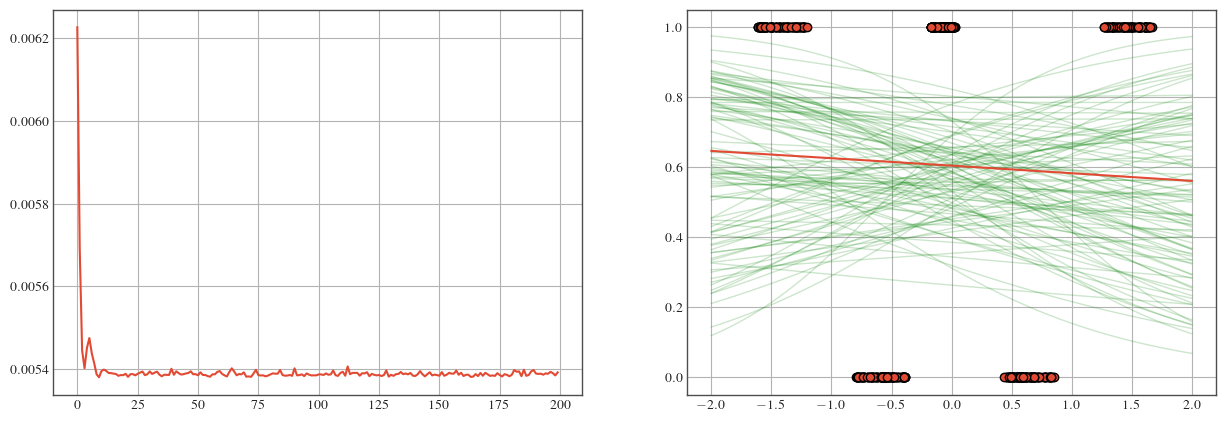

2
{'train_loss': 0.004057158250361681}


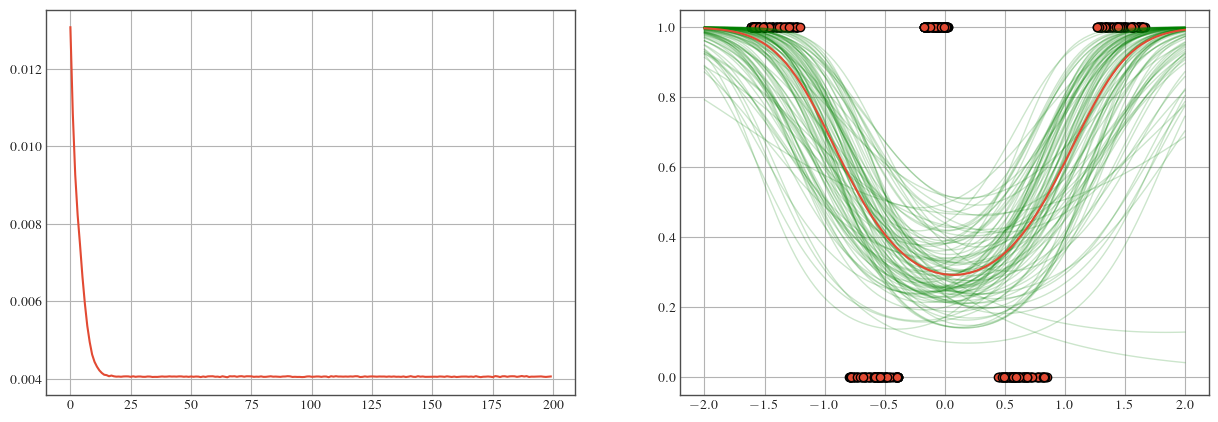

3
{'train_loss': 0.004037742502987385}


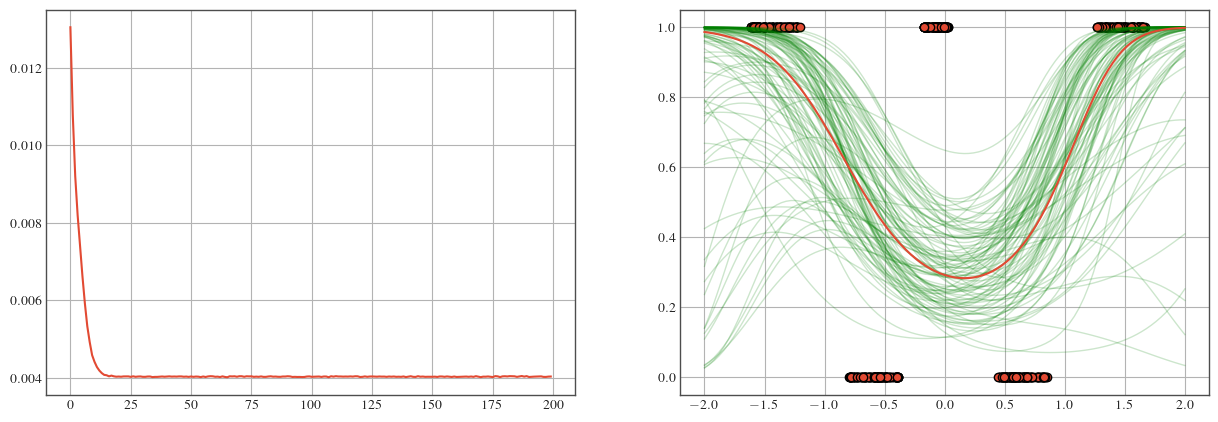

4
{'train_loss': 0.0015304151456803083}


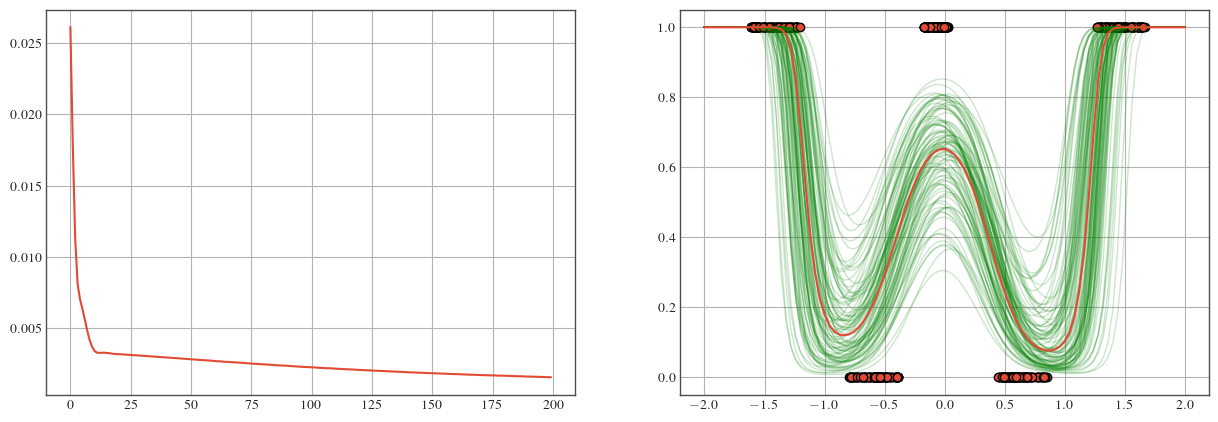

5
{'train_loss': 0.001476862351410091}


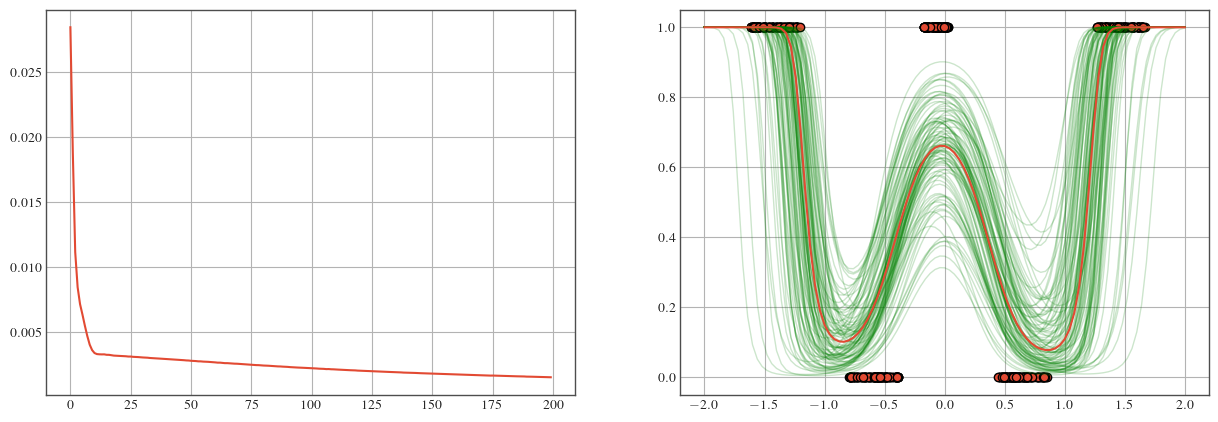

6
{'train_loss': 0.0006981955957598984}


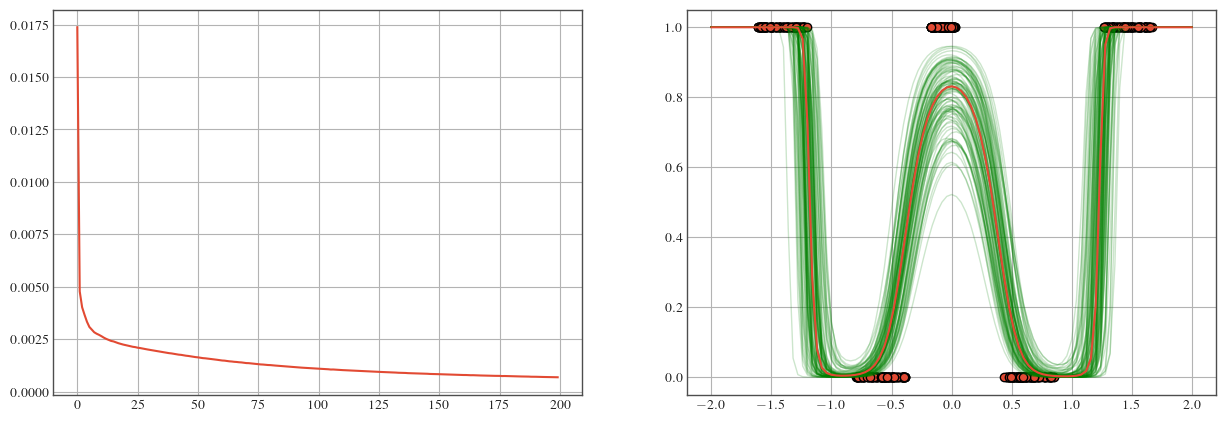

7
{'train_loss': 0.0006848206394352019}


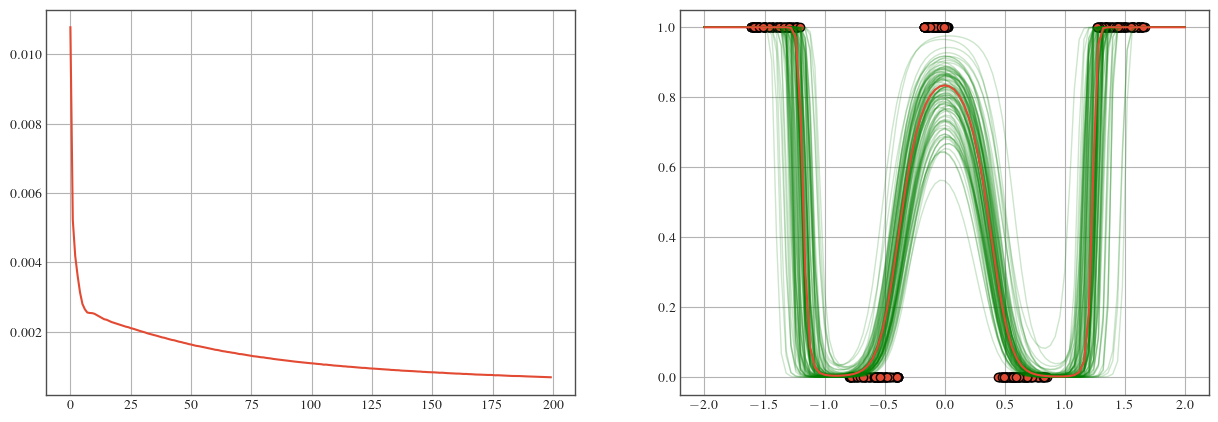

8
{'train_loss': 0.000856212165672332}


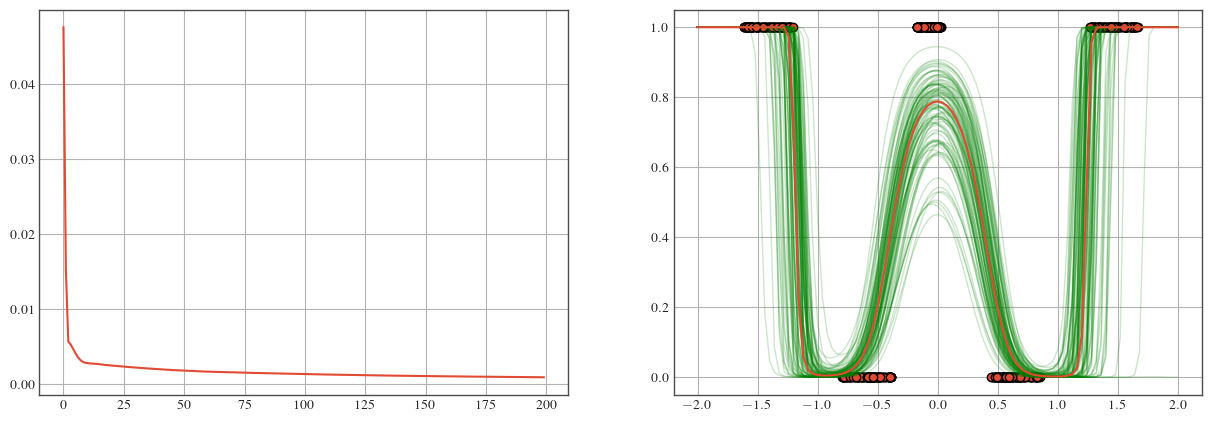

9
{'train_loss': 0.000921370112337172}


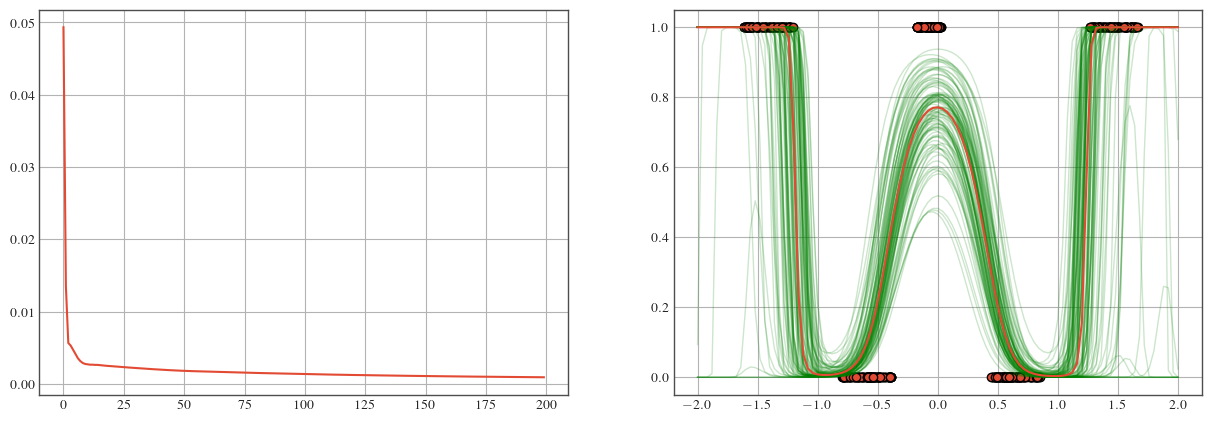

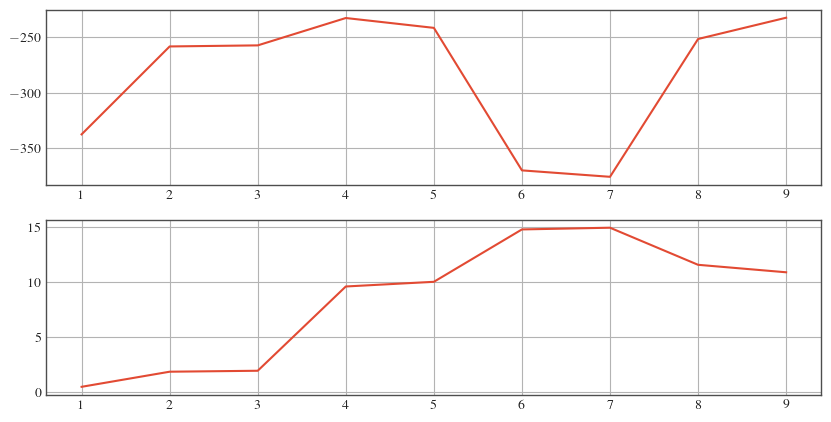

In [275]:
n_epochs = 200
orders = range(1, 10)
lmls = []
norms = []
for order in orders:
    print(order)
    torch.manual_seed(0)

    model = LinearModelClassification(order=order)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-1, weight_decay=1e-2)
    train_loader = torch.utils.data.DataLoader(train_ds, batch_size=128, shuffle=True)

    history = []
    for i in range(n_epochs):
        train_stats = train_one_epoch(model, train_loader, optimizer)
        history.append(train_stats)

    # Laplace approximation
    model.compute_precision(X)
    mean = model.weight.data
    prec = model.precision
    posterior = torch.distributions.MultivariateNormal(mean, precision_matrix=prec)
    lml =  model.log_marg_likelihood(X, y)
    lmls.append(lml)
    norms.append(torch.norm(model.weight.detach()))

    model.eval()
    print(history[-1])
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.plot([d['train_loss'] for d in history])
    plt.subplot(122)
    plt.scatter(X, y)
    axis = torch.linspace(-2, 2, 101)
    with torch.no_grad():
        logits_axis = model(axis.view(-1, 1)).squeeze()
    probas_axis = logits_axis.sigmoid()
    for w in posterior.sample((100,)):
        phi = model.phi(axis.view(-1, 1))
        out = F.linear(phi, w).sigmoid().squeeze()
        plt.plot(axis, out, color='g', linewidth=1, alpha=.2)

    plt.plot(axis, probas_axis)
    
    plt.show()

plt.subplot(211)
plt.plot(orders, lmls)
plt.subplot(212)
plt.plot(orders, norms)
plt.show()